In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import jax
import optax
import jaxopt
from flax import linen as nn
from jax import numpy as jnp
from flax.training import train_state  # Useful dataclass to keep train state
import flax

from functools import partial
import pickle

from numerical_methods import physics

In [2]:
dx, dy = 0.5, 0.5
ny, nx = 26, 49
dt=0.1

## Dataset

In [3]:
TIMES = jnp.load("dataset/times.npy")

TERRAIN = jnp.load("dataset/terrain.npy")

INFLOW_LOCS = jnp.load("dataset/inflow_locations.npy")

rel_loc = [(0, -1), (0, 0), (1, -1), (1, 0)]
INFLOW_COEFFS = jnp.load("dataset/inflow_poly_coeffs.npy")

TRAIN_SET = jnp.load("dataset/train_smoke_grid.npy")

VELOCITY = jnp.load("dataset/velocity_2d.npy")

## Forward Simulation Function

In [4]:
@jax.jit
def conv_diff_single_step(params,
                          smoke_initial: jnp.array,
                          velocity: jnp.array,
                          time_curr: float,
                          inflow_loc: jnp.array,
                          inflow_poly_coeffs: jnp.array,
                          terrain: jnp.array,
                          dt: float):
    # set smoke at inflow locations
    y,x = inflow_loc
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_curr)
        smoke_initial = smoke_initial.at[y+rel_y, x+rel_x].set(c)
    
    advection_term = physics.advect_corr_fvm(field=smoke_initial, 
                                             velocity=velocity,
                                             u_corr=params['u_corr'],
                                             v_corr=params['v_corr'], 
                                             dx=dx, 
                                             dy=dy) * dt
    
    diffusion_term = physics.diffuse_2d_fvm(field=smoke_initial, 
                                            diffusivity_x=params['diffusivity_x'],
                                            diffusivity_y=params['diffusivity_y'],
                                            dx=dx, 
                                            dy=dy) * dt
    smoke_pred = smoke_initial\
                    + advection_term\
                    + diffusion_term
    
    time_next = time_curr + dt
    for i in range(len(rel_loc)):
        rel_y, rel_x = rel_loc[i]
        c = jnp.polyval(inflow_poly_coeffs[i], time_next)
        smoke_pred = smoke_pred.at[y+rel_y, x+rel_x].set(c)
    
    smoke_pred = smoke_pred * terrain
    smoke_pred = jnp.maximum(smoke_pred, 0.0)
    return (smoke_pred, time_next, params, inflow_loc, inflow_poly_coeffs), None

step_for_loop = lambda carry, x: conv_diff_single_step(params=carry[2],
                                                        smoke_initial=carry[0],
                                                        velocity=VELOCITY,
                                                        time_curr=carry[1],
                                                        inflow_loc=carry[3],
                                                        inflow_poly_coeffs=carry[4],
                                                        terrain=TERRAIN,
                                                        dt=dt)

@partial(jax.jit, static_argnames=['nsteps'])
def conv_diff_nsteps(params, smoke_initial: jnp.array, time_initial, inflow_loc, inflow_poly_coeffs,nsteps):
    (smoke_pred, _, _, _, _), _ = jax.lax.scan(step_for_loop, (smoke_initial, time_initial, params, inflow_loc, inflow_poly_coeffs), xs=None, length=nsteps)
    return smoke_pred

## Forward Simulation

In [5]:
def create_train_state(diffusivity_x, diffusivity_y, u_corr, v_corr, learning_rate):
    params = {}
    params['diffusivity_x'] = diffusivity_x
    params['diffusivity_y'] = diffusivity_y
    params['u_corr'] = u_corr
    params['v_corr'] = v_corr
  
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=conv_diff_nsteps,
                                         params=params,
                                         tx=tx)

# state = create_train_state(diffusivity_x=jnp.zeros((ny,nx-1)),
#                            diffusivity_y=jnp.zeros((ny-1,nx)),
#                            u_corr=jnp.zeros((ny,nx-1)),
#                            v_corr=jnp.zeros((ny-1,nx)),
#                            learning_rate=1e-4)

# with open('v2_3_phase1_diffusivity_final.pickle', 'rb') as bunch:
#     state_dict = pickle.load(bunch)

# state = flax.serialization.from_state_dict(state, state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'v2_3_phase1_diffusivity_final.pickle'

In [6]:
# with open('params_physics.pickle', 'wb') as handle:
#     pickle.dump(state.params, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('ckpt/phase_2/unet/params_physics.pickle', 'rb') as handle:
    params_physics = pickle.load(handle)

Text(0.5, 1.0, 'v corection')

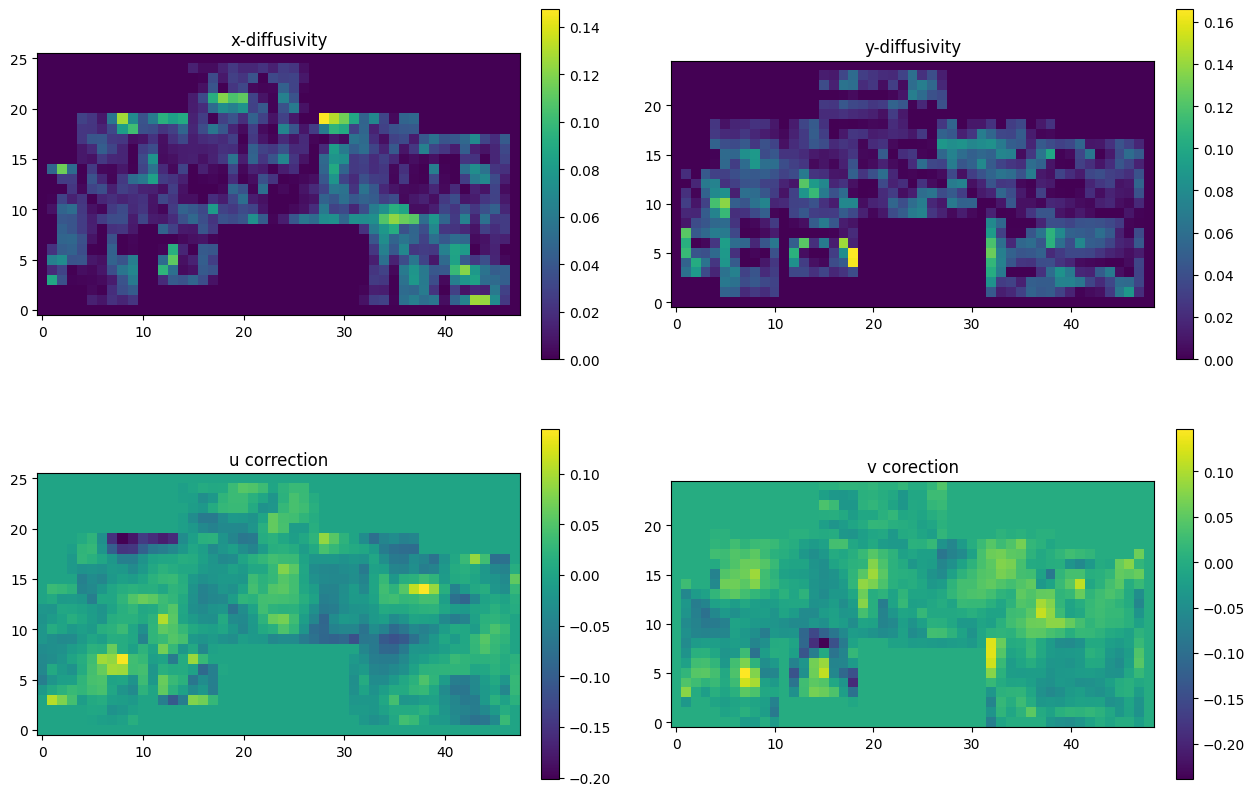

In [7]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,2,1)
im = plt.imshow(params_physics['diffusivity_x'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("x-diffusivity")
fig.add_subplot(2,2,2)
im = plt.imshow(params_physics['diffusivity_y'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("y-diffusivity")
fig.add_subplot(2,2,3)
im = plt.imshow(params_physics['u_corr'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("u correction")
fig.add_subplot(2,2,4)
im = plt.imshow(params_physics['v_corr'], origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("v corection")


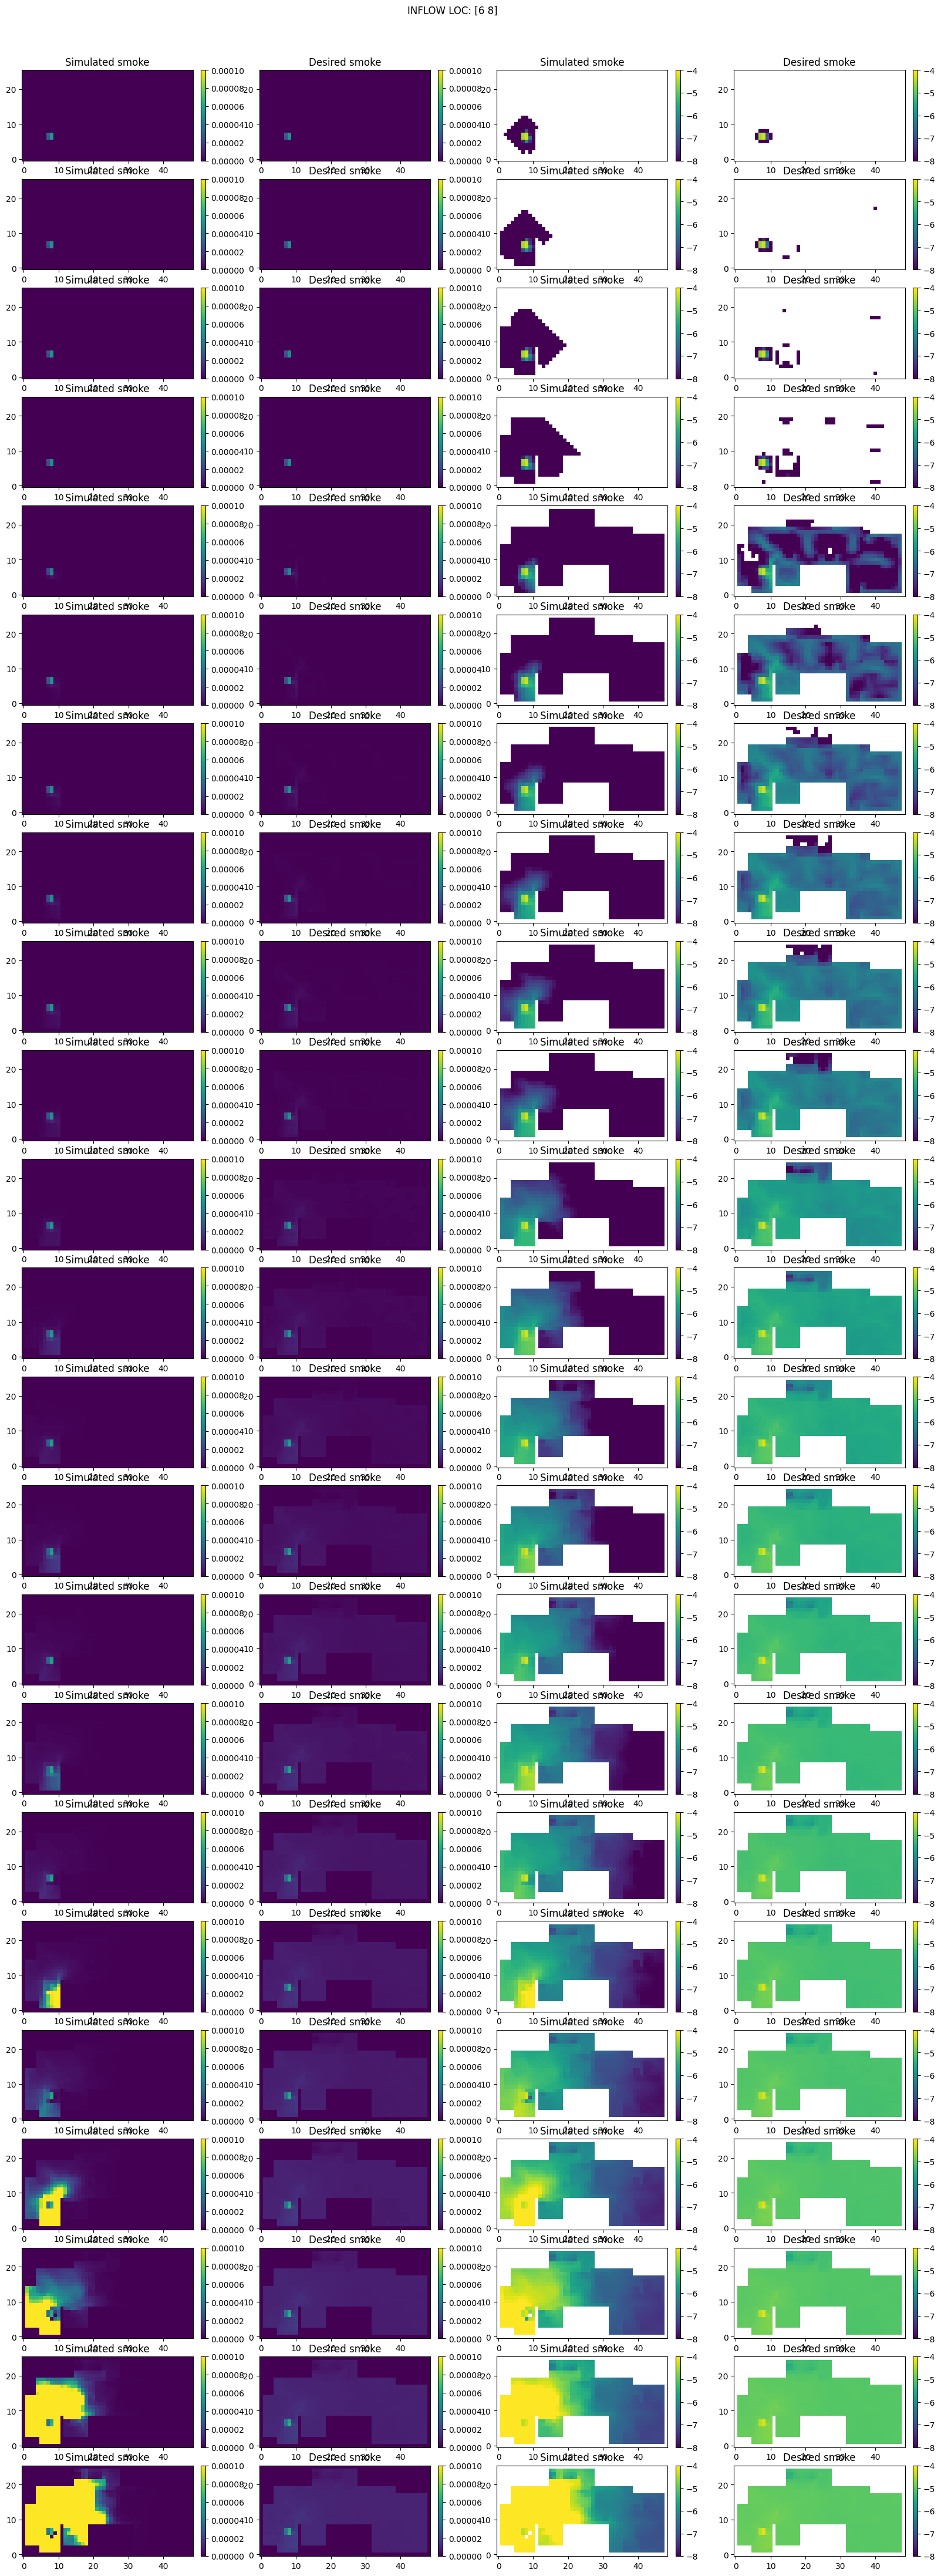

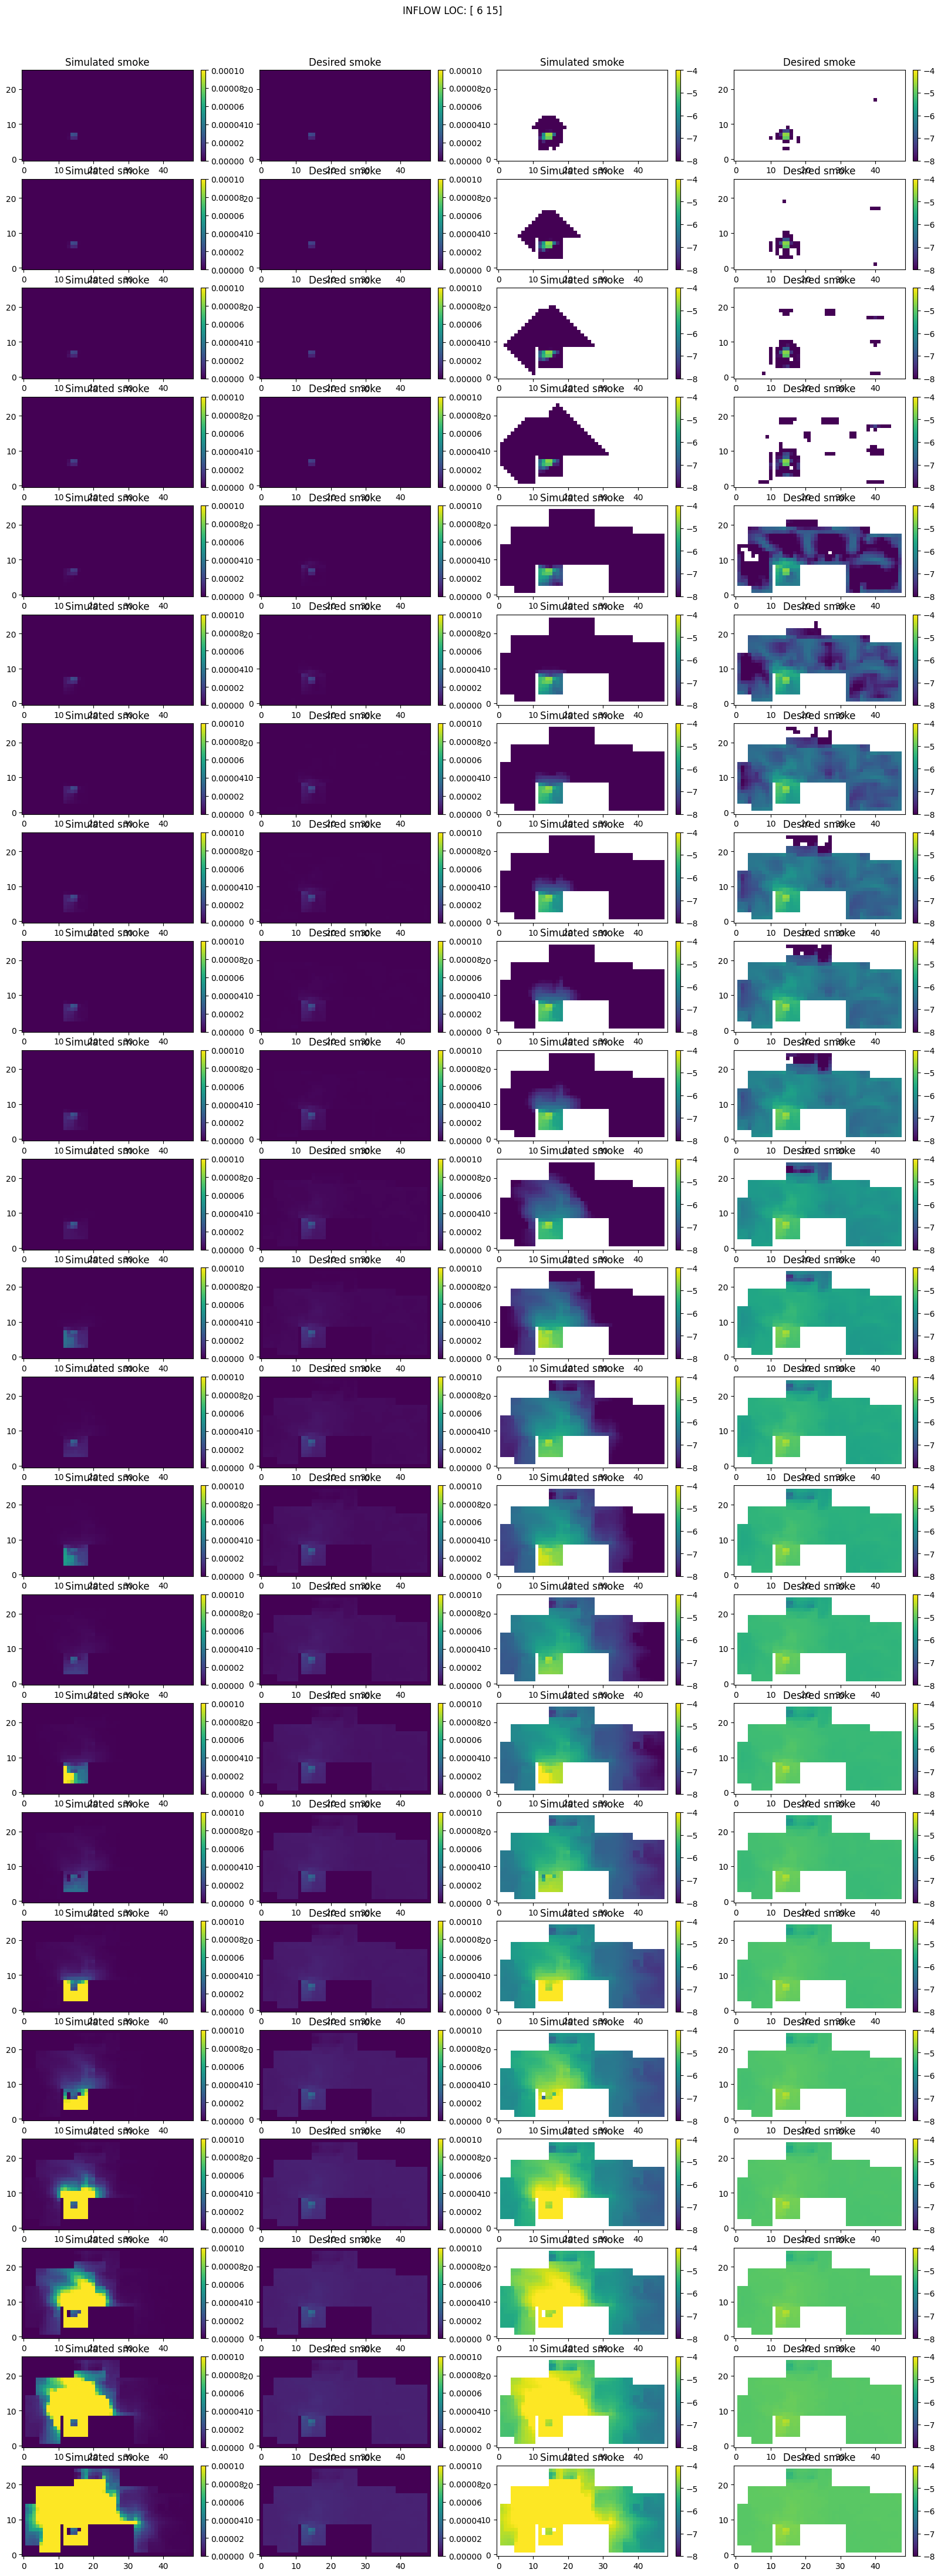

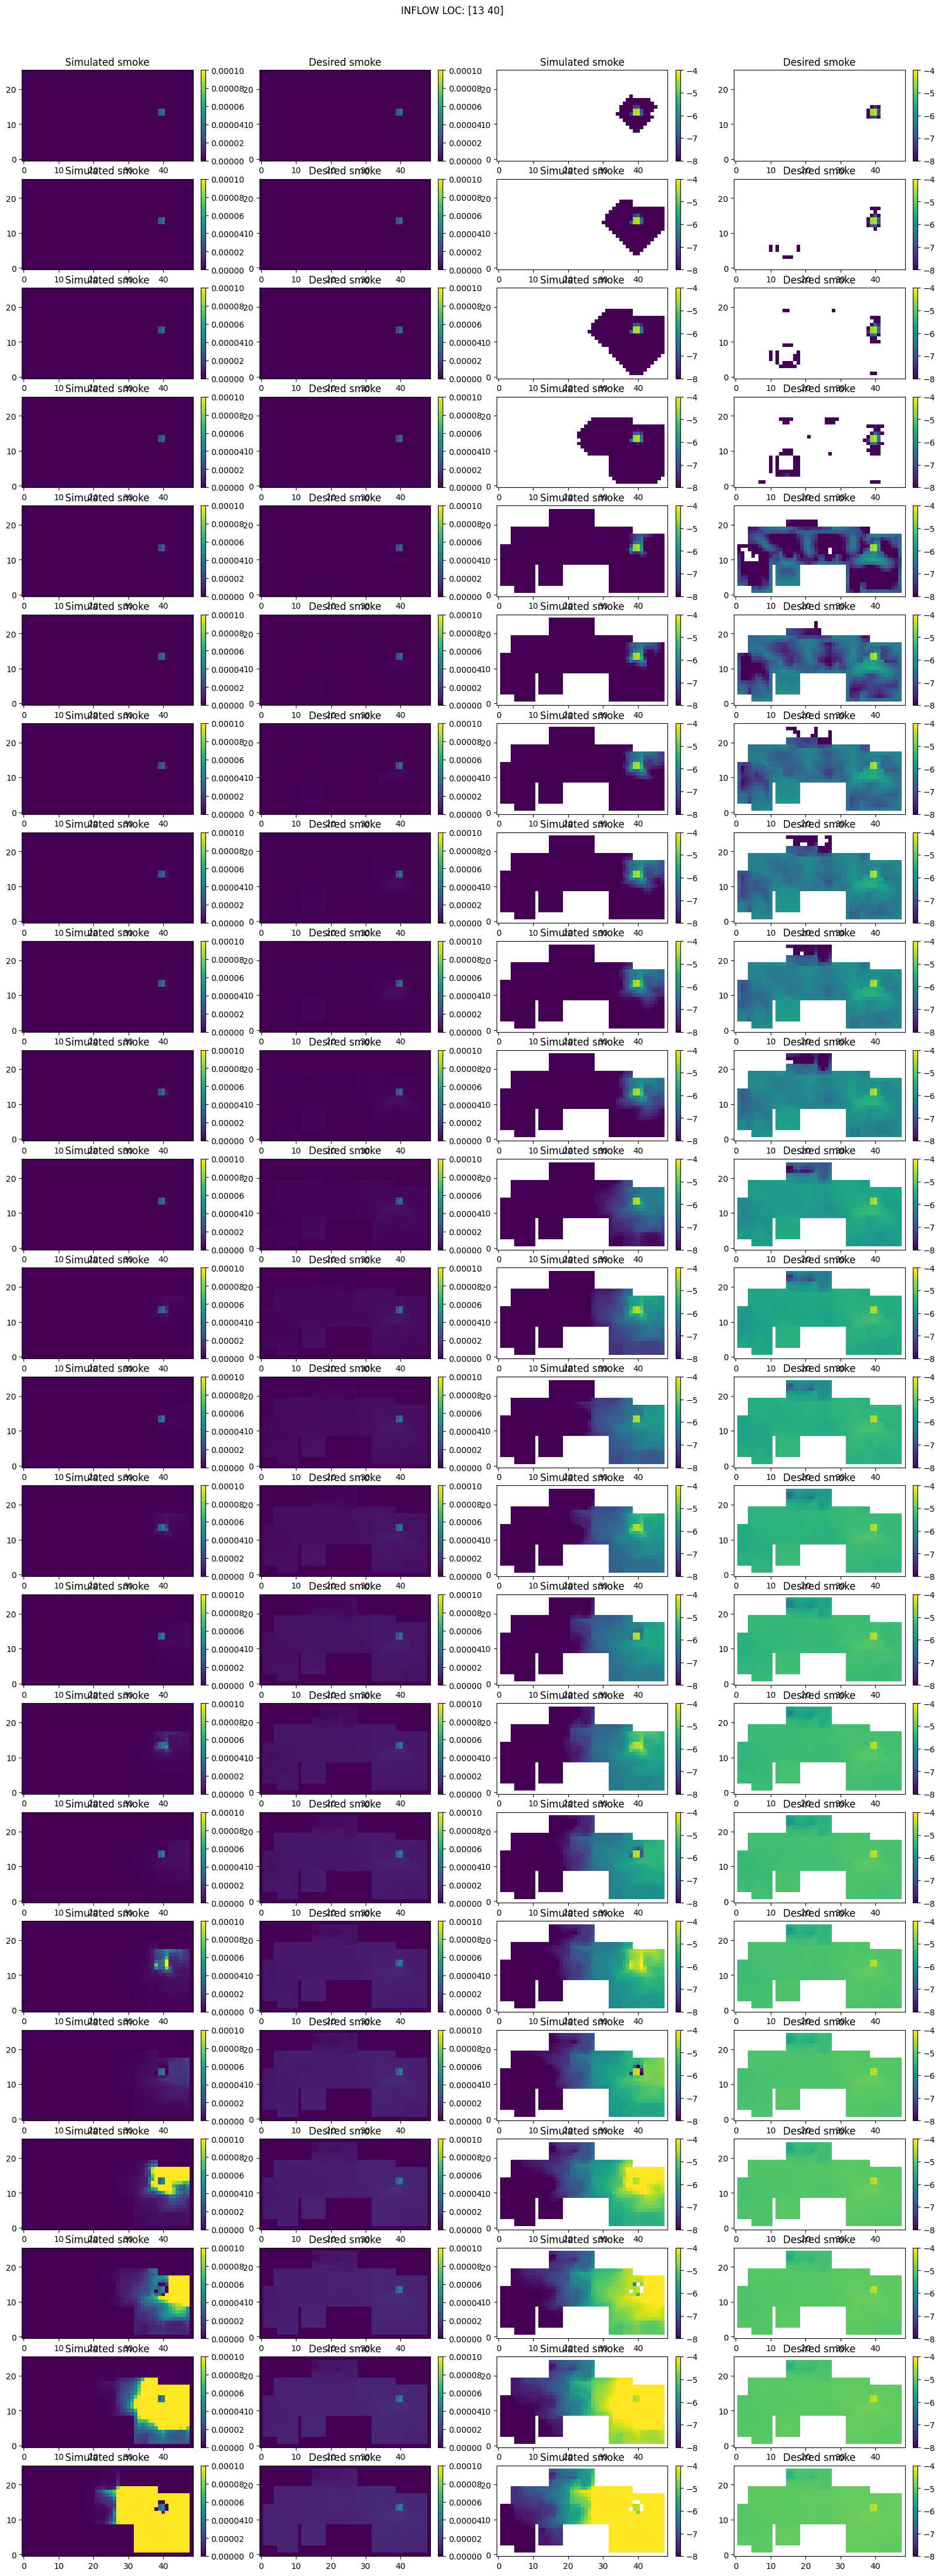

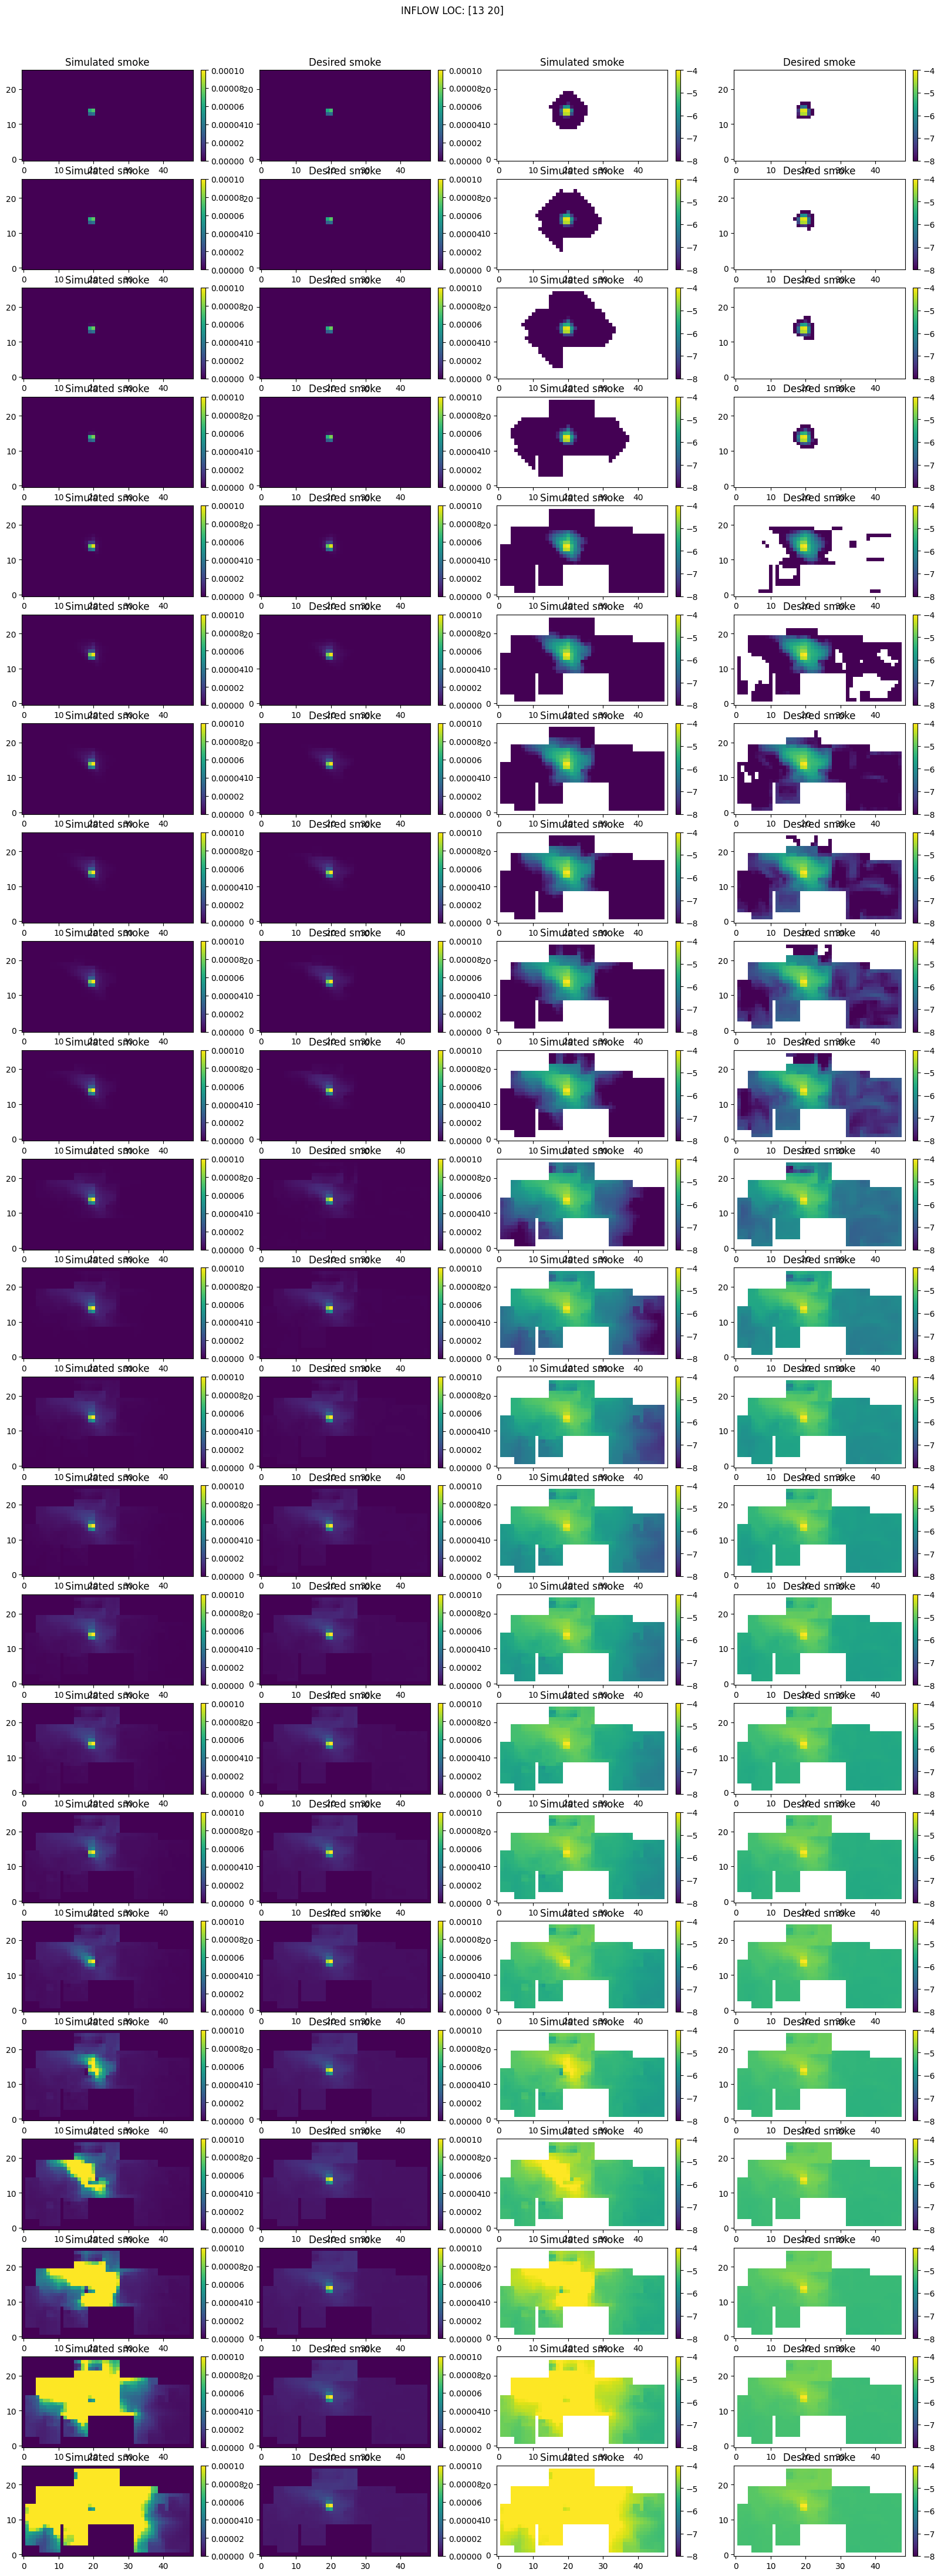

In [8]:
losses_all_set = []

for set_idx in range(len(TRAIN_SET)):
    losses = []
    smoke_curr = TRAIN_SET[set_idx][0]
    time_curr = TIMES[0]

    fig = plt.figure(figsize=(20,55))
    plt.suptitle(f"INFLOW LOC: {INFLOW_LOCS[set_idx]}", y=0.9)
    for i in range(23):

        nsteps = int((TIMES[i+1]-TIMES[i]+1e-3)/dt)
        for j in range(nsteps):
            (smoke_curr, time_curr, params, inflow_loc, inflow_poly_coeffs), x = \
            conv_diff_single_step(params=params_physics,
                                smoke_initial=smoke_curr,
                                velocity=VELOCITY,
                                time_curr=time_curr,
                                inflow_loc=INFLOW_LOCS[set_idx],
                                inflow_poly_coeffs=INFLOW_COEFFS[set_idx],
                                terrain=TERRAIN,
                                dt=dt)
        
        
        fig.add_subplot(23,4,i*4+1)
        im = plt.imshow(smoke_curr, vmin=0, vmax=1e-4, origin='lower')
        plt.title("Simulated smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+2)
        im = plt.imshow(TRAIN_SET[set_idx][i+1], vmin=0, vmax=1e-4, origin='lower')
        plt.title("Desired smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+3)
        im = plt.imshow(jnp.log10(smoke_curr), vmin=-8, vmax=-4, origin='lower')
        plt.title("Simulated smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        fig.add_subplot(23,4,i*4+4)
        im = plt.imshow(jnp.log10(TRAIN_SET[set_idx][i+1]), vmin=-8, vmax=-4, origin='lower')
        plt.title("Desired smoke")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        losses.append(jnp.sum(optax.l2_loss(smoke_curr, TRAIN_SET[set_idx][i+1])))

    plt.show()

    losses_all_set.append(losses)
    

Text(0, 0.5, 'Loss')

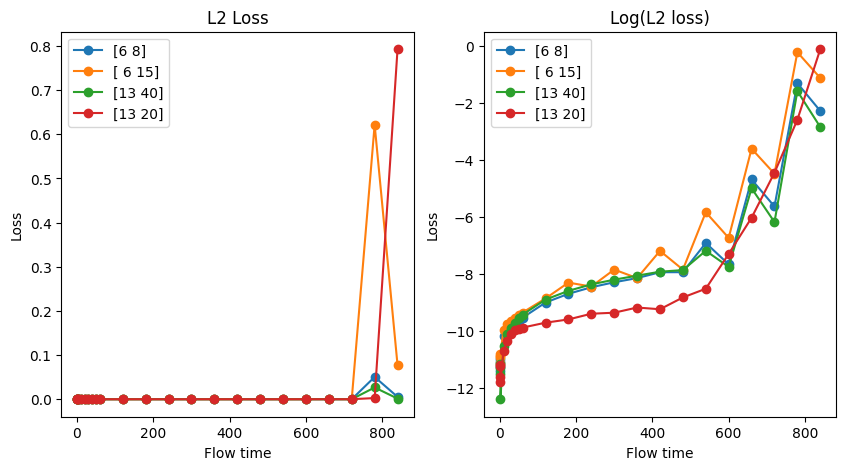

In [9]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.title("L2 Loss")
for i in range(len(losses_all_set)):
    plt.plot(TIMES[1:], losses_all_set[i], marker='o', label=f"{INFLOW_LOCS[i]}")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")
fig.add_subplot(1,2,2)
plt.title("Log(L2 loss)")
for i in range(len(losses_all_set)):
    plt.plot(TIMES[1:], np.log10(losses_all_set[i]), marker='o', label=f"{INFLOW_LOCS[i]}")
plt.legend()
plt.xlabel("Flow time")
plt.ylabel("Loss")